## Libraries

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
import numpy as np
import random

## Data

we take 25 years of OHLCV data for microsoft

In [2]:
import yfinance as yf
import pandas as pd
data = yf.Ticker("MSFT")
data = data.history(start = "2000-01-01", end = "2025-10-01")
data = data.reset_index(drop = True)

data = data[["Open", "High", "Low", "Close", "Volume"]]
data

,Open,High,Low,Close,Volume
0,35.849597,36.231382,34.207922,35.601437,53228400
1,34.685173,35.773260,34.284299,34.398834,54119000
2,33.940694,35.544191,33.406195,34.761532,64059600
3,34.265200,34.780610,33.100756,33.597076,54976600
4,33.177117,34.284293,32.776242,34.036133,62013600
...,...,...,...,...,...
6470,509.426542,511.522594,505.973014,509.196960,13533700
6471,507.350411,509.057238,504.096522,506.082794,15786500
6472,509.107138,512.979895,505.673562,510.504517,16213100
6473,510.544427,515.884407,507.929326,513.638611,17617800


## Features

We design features for our future strategy implementation

In order to make a few hints and ease of access, I have added 
- Returns
- Simple moving averages
- Exponential moving averages
- sign of distance from moving average to price

In [3]:
data['returns'] = data['Close'].diff()/data['Close'].shift(1)
data['returns'].loc[data['returns'].isna()] = 0

# Simple moving averages
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA40'] = data['Close'].rolling(window=40).mean()
data['MA120']= data['Close'].rolling(window=120).mean()

# Exponential moving averages
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA40']  = data['Close'].ewm(span=40, adjust=False).mean()
data['EMA120']  = data['Close'].ewm(span=120, adjust=False).mean()

# Sign of distance from current close to moving averages
data["sma-s"] = np.sign(data["Close"] - data["MA20"])
data["mma-s"] = np.sign(data["Close"] - data["MA40"])
data["lma-s"] = np.sign(data["Close"] - data["MA120"])

# Sign of distance from current close to Exp moving averages
data["sEma-s"] = np.sign(data["Close"] - data['EMA20'])
data["mEma-s"] = np.sign(data["Close"] - data["EMA40"])
data["lEma-s"] = np.sign(data["Close"] - data["EMA120"])

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_17184\2192863853.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['returns'].loc[data['returns'].isna()] = 0
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_17184\2192863853.py:2:

## Strategy

### Buy condition

if the current close price is above the short moving average


and the current close price is below the long moving average. 

Buy!

In [4]:
def MA_BUY(data):
    if data['Close'] < data['MA20'] and data['Close'] < data['MA40']:
        return(True)
    else:
        return(False)


### Sell condition

If the current close price is below the short moving average 

and the current close price is above the long moving average. 

Sell!

In [5]:
def MA_SELL(data):
    if data['Close'] > data['MA20'] and data['Close'] > data['MA40']:
        return(True)
    else:
        return(False)


## Backtest

This is a very simple backtesting script, used to run your strategy with your buy and sell conditions on the entire 25 years of data taken for MSFT stock

In [6]:
signal = []
val = 100
value = []
inv = []
_inv = 0
inventory_state = "buy"

for i in range(len(data)-1): 

    
    if MA_BUY(data.loc[i]) == True and inventory_state == "buy":

        if val > 0:
            signal.append(["buy",i])
            _inv = val / data['Close'][i]
            val = val - _inv * data['Close'][i]
            inventory_state = "sell"
        else:
            val = val
            _inv = _inv
        
    if MA_SELL(data.loc[i]) == True and inventory_state == "sell":
        
        if _inv > 0:
            signal.append(["sell",i])
            val = val + _inv * data['Close'][i]
            _inv = _inv - _inv
            inventory_state = "buy"
        else:
            val = val
            _inv = _inv
    
    
    inv.append(_inv)
    value.append(val)
            
    
signal = pd.DataFrame(signal, columns = ["Type", "Index"])
print("This is your value at the end:", val, "$")
print("This is your inventory at the end:", _inv)
print("Annualised return: ", round((((value[-1]/value[0])**(1/25)-1)*100),2),"%")

This is your value at the end: 1054.2345363997003 $
This is your inventory at the end: 0.0
Annualised return:  9.88 %


### result
These graphs show the inventory over time and the value of your portfolio over time.

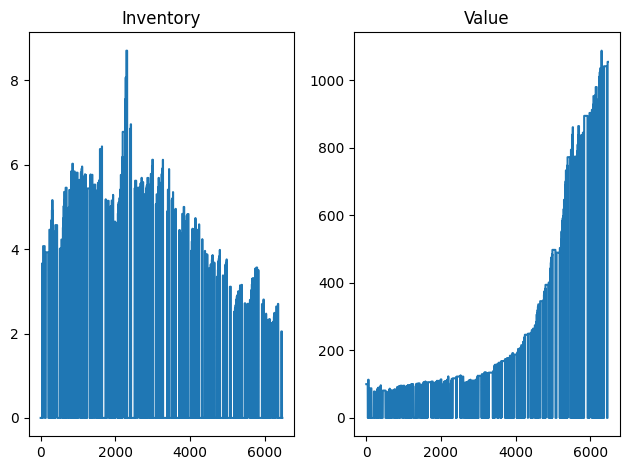

In [7]:
plt.subplot(1, 2, 1)
plt.plot(inv)
plt.title("Inventory")

plt.subplot(1, 2, 2)
plt.plot(value)
plt.title("Value")

plt.tight_layout() 
plt.show()

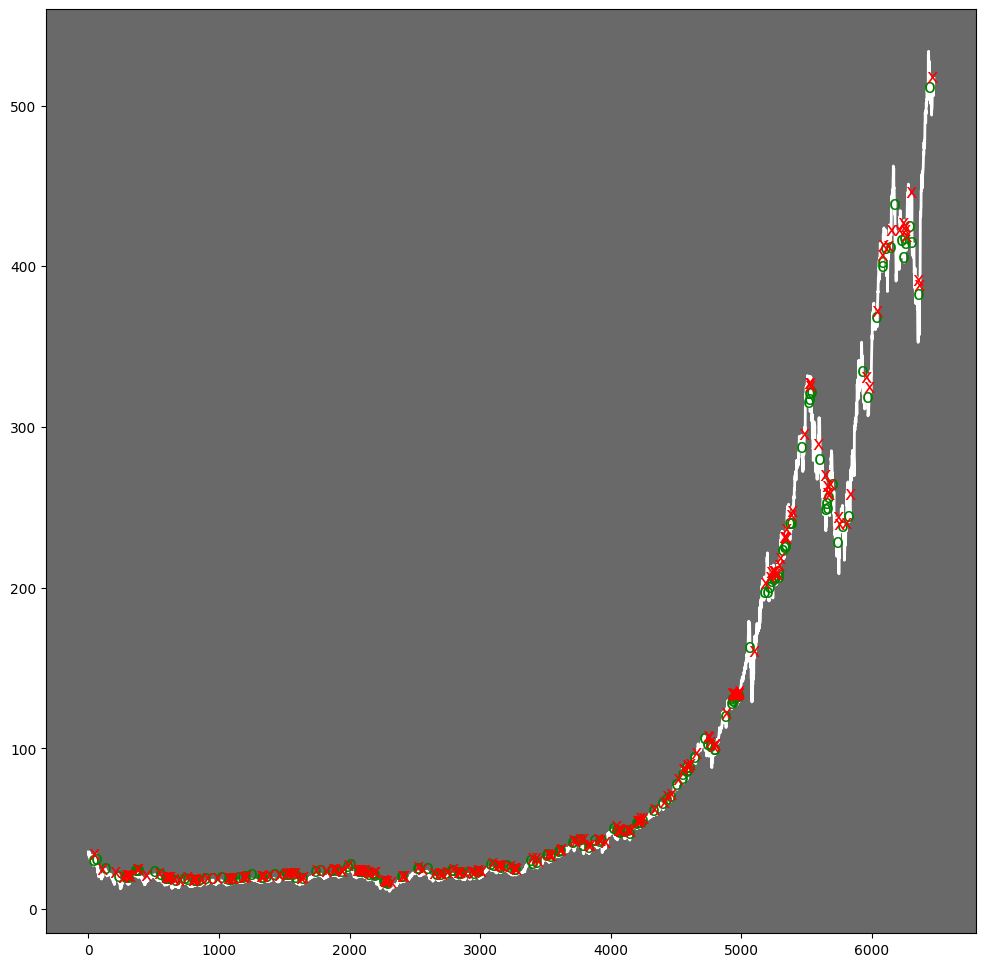

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

# Price plot
ax1.set_facecolor('dimgrey')
ax1.plot(data.index, data['Close'], linewidth = 2, color = "white")

# buy signal
buy = signal[signal["Type"] == "buy"]
buy_signal_indx = list(buy.Index)
for i in buy_signal_indx:
    ax1.annotate('o', xy=(i, data.iloc[i, 3]), color='green', fontsize=14, ha='center', alpha = 1)

# sell signal  
sell = signal[signal["Type"] == "sell"]
sell_signal_indx = list(sell.Index)
for i in sell_signal_indx:
    ax1.annotate('x', xy=(i, data.iloc[i, 3]), color='red', fontsize=14, ha='center', alpha = 1)

#plt.ylim(0, 40)
#plt.xlim(0,1000)
plt.show()

This graph shows the price and your strategy actions.\
Green for buy(entries)\
red for sell(exits)